# LSTM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
np.random.seed(42)

## Data upload

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv', usecols=[1])

In [5]:
df

,Open
0,234.05
1,234.55
2,240.00
3,233.30
4,233.55
...,...
2030,117.60
2031,120.10
2032,121.80
2033,120.30


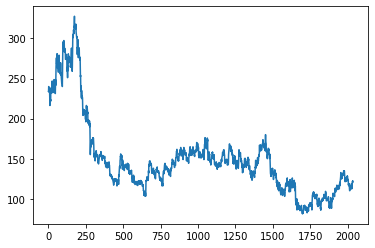

In [6]:
plt.plot(df)
plt.show()

## Preprocessing data

In [7]:
dataset = df.values
dataset = dataset.astype('float32')

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1363 672


In [10]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [11]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Model

In [13]:
model = Sequential()
model.add(Bidirectional(LSTM(4, dropout=0.2, return_sequences=True), input_shape=(1, look_back)))
model.add(Bidirectional(LSTM(4, dropout=0.2)))
model.add(Dense(1))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 8)              192       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0310
Epoch 2/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0141
Epoch 3/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0125
Epoch 4/100
1361/1361 [==============================] - 9s 6ms/step - loss: 0.0112
Epoch 5/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0126
Epoch 6/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0098
Epoch 7/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0090
Epoch 8/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0086
Epoch 9/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0068
Epoch 10/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0071
Epoch 11/100
1361/1361 [==============================] - 8s 6ms/step - loss: 0.0048
Epoch 12/100
1361/1361 [==============================] - 8s 6ms/step - lo

## Model evaluation

In [17]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 18.96 RMSE
Test Score: 20.36 RMSE


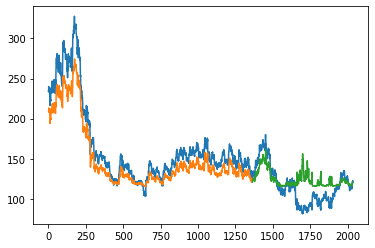

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()